In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import SimpleITK as sitk
from tqdm import tqdm
from timeit import default_timer as timer
plt.rcParams["figure.figsize"] = (20,5)
sitk.ProcessObject_SetGlobalWarningDisplay(False)

In [3]:
# get data dir
TRAIN_DIR = "./data/train/"
OUTPUT_DIR = "./processed/train"
EXAMPLE = TRAIN_DIR + "00009/FLAIR"

In [15]:
def read_dicom_series(path):
    """
    reads a dicom series (a list of files) represented by the input path
    
    args:
    path -- the path to the dicom folder
    """
    reader = sitk.ImageSeriesReader()
    fpaths = reader.GetGDCMSeriesFileNames(path)
    reader.SetFileNames(fpaths)
    return sitk.Cast(reader.Execute(), sitk.sitkFloat32)

def show_image(im):
    fig, axs = plt.subplots(1,3)
    arr = sitk.GetArrayFromImage(im)
    imax = np.max(arr)

    axs[0].imshow(
        arr[arr.shape[0]//2,:,:],
        aspect='auto', vmax=imax)
    axs[0].set_title("normal 0")
    axs[1].imshow(
        arr[:,arr.shape[1]//2,:],
        aspect='auto', vmax=imax)
    axs[1].set_title("normal 1")
    axs[2].imshow(
        arr[:,:,arr.shape[2]//2],
        aspect='auto', vmax=imax)
    axs[2].set_title("normal 2")

def resample_image(image, resample_spacing=None):
    """
    resamples a SimpleITK image
    """
    if resample_spacing == None:
        return image 
    else:
        # get pre voxel size and image size
        pre_vs = image.GetSpacing()
        pre_is = image.GetSize()
        
        # calculate post voxel size and
        post_is = [
            int(np.round(pre_is[0] * (pre_vs[0] / 2))),
            int(np.round(pre_is[1] * (pre_vs[1] / 2))),
            int(np.round(pre_is[2] * (pre_vs[2] / 2))) 
        ]
        
        return sitk.Resample(
            image1 = image,
            size = post_is,
            transform = sitk.Transform(),
            interpolator = sitk.sitkBSpline,
            outputOrigin = image.GetOrigin(),
            outputSpacing = resample_spacing,
            outputDirection = image.GetDirection(),
            defaultPixelValue = 0.0,
            outputPixelType = image.GetPixelID()
        )

def permute_norm(x, plane):
    norm_hash =  x[1] + 2*x[2]
    if plane == "Axial":
        return int(norm_hash)
    elif plane == "Sagittal":
        raise NotImplementedError
    elif plane == "Coronal":
        raise NotImplementedError
    else:
        raise ValueError("Specified Plane does not exist")

def rotate_image(image, plane="Axial"):
    pre_norms = np.abs(np.round(image.GetDirection()))
    pre_norms = pre_norms.astype(int)
    
    # calculate the permutation for each normal vector and wrap in tuple
    post_norms = [
        permute_norm(pre_norms[0:3], plane),
        permute_norm(pre_norms[3:6], plane),
        permute_norm(pre_norms[6:9], plane)
    ]    
    
    return sitk.PermuteAxes(image, post_norms)

def n4_bias_correction(image, fit_level = 4, num_iterations = 50, hist_bins = 200):
    # if mask is not specified then set mask to default
    mask = sitk.OtsuThreshold(image, 0, 1, 200)
    
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrector.SetMaximumNumberOfIterations([num_iterations] * fit_level)    
    corrector.SetNumberOfHistogramBins(hist_bins)
    
    return corrector.Execute(image, mask)
    
    


1.85339999916323e-05


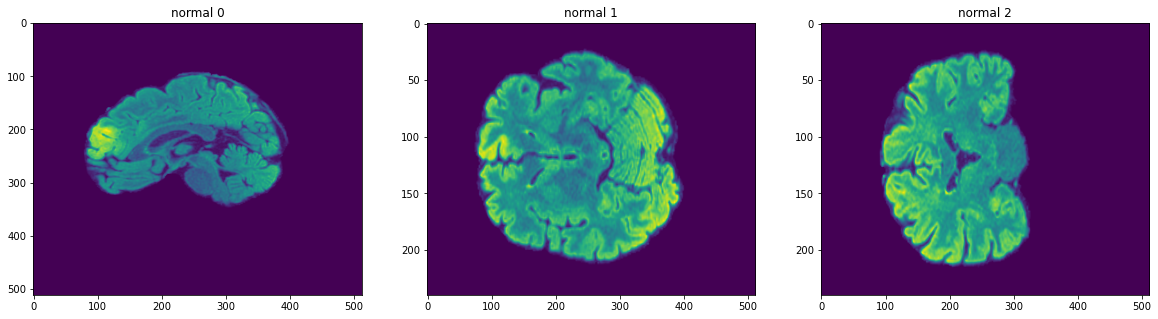

In [13]:
image = read_dicom_series(EXAMPLE)
start = timer()
# resampledImage = resample_image(image, [2,2,2])
# correctedImage = n4_bias_correction(image)
end = timer()
print(end - start)
show_image(image)

In [6]:
show_image(correctedImage)

NameError: name 'correctedImage' is not defined

In [7]:
# define more helpers

def safe_make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [8]:
scan_type = "T1w"

sub_dirs = next(os.walk(TRAIN_DIR))[1]

# make output dirs if not exists
safe_make_dir("./processed")
safe_make_dir(OUTPUT_DIR)

# do preprocessing pipeline on flair for now
for x in tqdm(sub_dirs):
    FLAIR_DIR = TRAIN_DIR + x + "/" + scan_type
    XDIR = OUTPUT_DIR + "/" + x
    safe_make_dir(XDIR)
    
    # load series -> rotate image -> resample image 
    image = read_dicom_series(FLAIR_DIR)
    image = rotate_image(image)
    image = resample_image(image)
    
    # write image 
    sitk.WriteImage(image, XDIR + "/" + scan_type + ".nrrd")

  2%|▊                                       | 11/585 [00:03<03:20,  2.87it/s]


KeyboardInterrupt: 

0.15485246


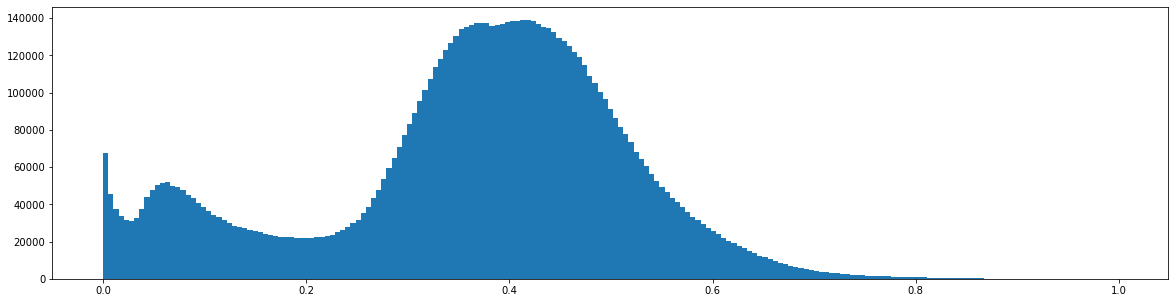

In [24]:
pix = sitk.GetArrayFromImage(image).flatten()
pix = pix[np.nonzero(pix)]
pix_min = np.min(pix)
pix_max = np.max(pix)

# min max normalize 
pix = (pix - pix_min)/pix_max
print(pix.std())
plt.hist(pix, 197)
plt.show()

0.42042798


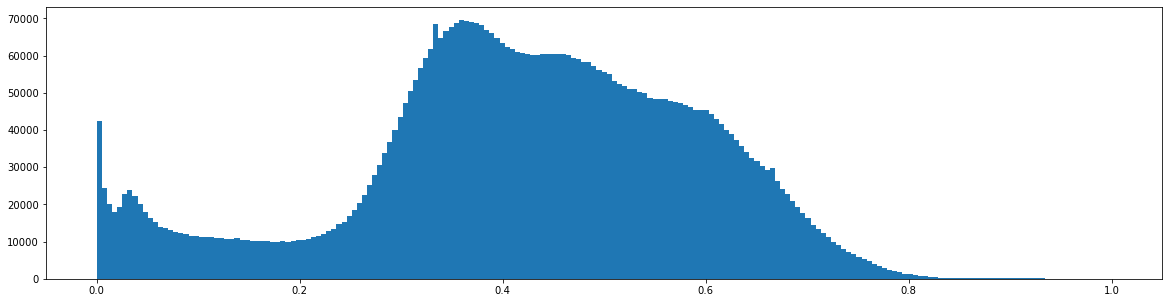

In [31]:
image2 = read_dicom_series(TRAIN_DIR + "00768/FLAIR")
# correctedImage2 = n4_bias_correction(image2)
pix = sitk.GetArrayFromImage(image2).flatten()
pix = pix[np.nonzero(pix)]
pix_min = np.min(pix)
pix_max = np.max(pix)

# min max normalize 
pix = (pix - pix_min)/pix_max
print(pix.mean())
plt.hist(pix, 199)
plt.show()

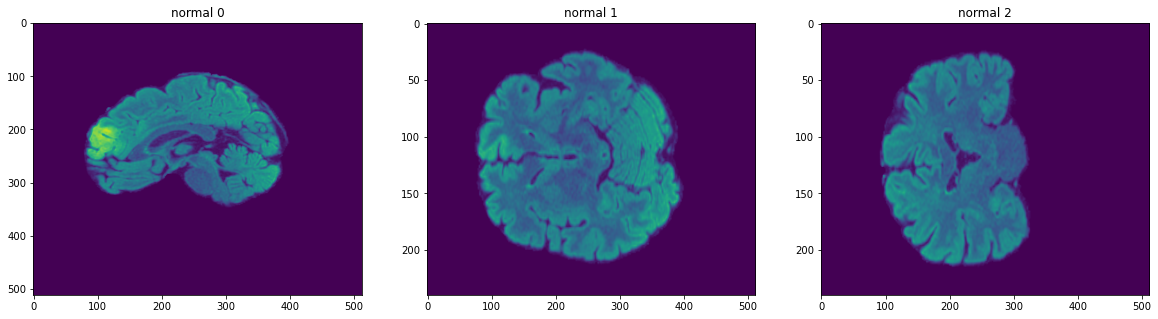

In [16]:
show_image(image)

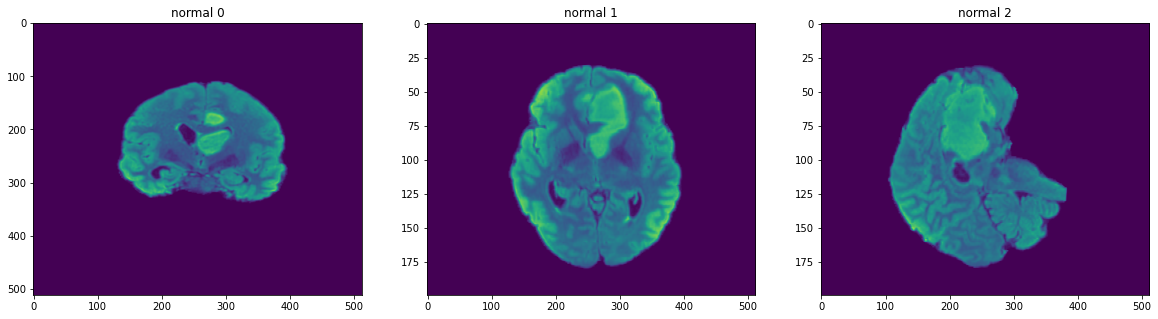

In [32]:
show_image(image2)

In [18]:
n4image = n4_bias_correction(image)
n4image2 = n4_bias_correction(image2)

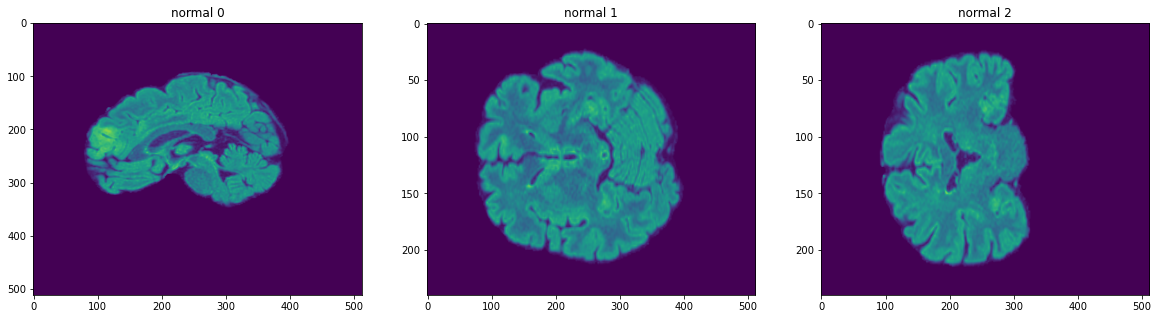

In [19]:
show_image(n4image)

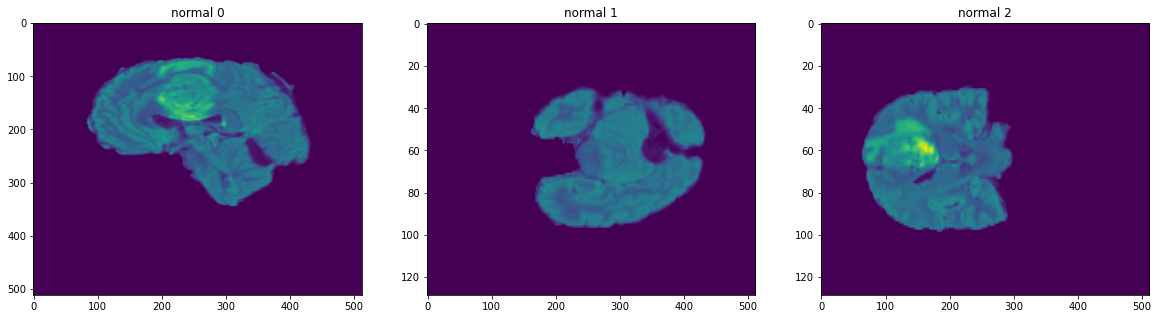

In [20]:
show_image(n4image2)